#**LTFS Top-up loan Up-sell prediction**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime 
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = pd.read_excel('/content/drive/MyDrive/Train.zip (Unzipped Files)/Train/train_Data.xlsx')
train_bureau = pd.read_excel('/content/drive/MyDrive/Train.zip (Unzipped Files)/Train/train_bureau.xlsx')
data_dict = pd.read_excel('/content/drive/MyDrive/Train.zip (Unzipped Files)/Train/data_dict.xlsx')

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128655 entries, 0 to 128654
Data columns (total 26 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ID               128655 non-null  int64         
 1   Frequency        128655 non-null  object        
 2   InstlmentMode    128655 non-null  object        
 3   LoanStatus       128655 non-null  object        
 4   PaymentMode      128655 non-null  object        
 5   BranchID         128655 non-null  int64         
 6   Area             117002 non-null  object        
 7   Tenure           128655 non-null  int64         
 8   AssetCost        128655 non-null  int64         
 9   AmountFinance    128655 non-null  float64       
 10  DisbursalAmount  128655 non-null  float64       
 11  EMI              128655 non-null  float64       
 12  DisbursalDate    128655 non-null  datetime64[ns]
 13  MaturityDAte     128654 non-null  datetime64[ns]
 14  AuthDate         128

In [ ]:
train_bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560844 entries, 0 to 560843
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   ID                         560844 non-null  int64         
 1   SELF-INDICATOR             560844 non-null  bool          
 2   MATCH-TYPE                 560844 non-null  object        
 3   ACCT-TYPE                  560844 non-null  object        
 4   CONTRIBUTOR-TYPE           560844 non-null  object        
 5   DATE-REPORTED              557161 non-null  datetime64[ns]
 6   OWNERSHIP-IND              560844 non-null  object        
 7   ACCOUNT-STATUS             560844 non-null  object        
 8   DISBURSED-DT               528694 non-null  datetime64[ns]
 9   CLOSE-DT                   309086 non-null  object        
 10  LAST-PAYMENT-DATE          241561 non-null  datetime64[ns]
 11  CREDIT-LIMIT/SANC AMT      15159 non-null   object  

In [ ]:
#Merge both dataframes to get a combined training dataframe
full_train = pd.merge(train_data, train_bureau, on='ID')

#drop any with more than 20% data missing
full_train_selected = full_train[full_train.columns[full_train.count()> 0.8*len(full_train)]]

full_train_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 560844 entries, 0 to 560843
Data columns (total 42 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   ID                         560844 non-null  int64         
 1   Frequency                  560844 non-null  object        
 2   InstlmentMode              560844 non-null  object        
 3   LoanStatus                 560844 non-null  object        
 4   PaymentMode                560844 non-null  object        
 5   BranchID                   560844 non-null  int64         
 6   Area                       515388 non-null  object        
 7   Tenure                     560844 non-null  int64         
 8   AssetCost                  560844 non-null  int64         
 9   AmountFinance              560844 non-null  float64       
 10  DisbursalAmount            560844 non-null  float64       
 11  EMI                        560844 non-null  float64 

In [ ]:
full_train_selected[['Area','ZiPCODE','City','State']] #so we use State because it has no null values

,Area,ZiPCODE,City,State
0,NaN,464993.0,RAISEN,MADHYA PRADESH
1,NaN,464993.0,RAISEN,MADHYA PRADESH
2,NaN,464993.0,RAISEN,MADHYA PRADESH
3,NaN,464993.0,RAISEN,MADHYA PRADESH
4,NaN,464993.0,RAISEN,MADHYA PRADESH
...,...,...,...,...
560839,PANIPAT,131024.0,SONIPAT,HARYANA
560840,PANIPAT,131024.0,SONIPAT,HARYANA
560841,PANIPAT,131024.0,SONIPAT,HARYANA
560842,PANIPAT,131103.0,SONIPAT,HARYANA


In [ ]:
columns_to_drop = ['Area','ZiPCODE','City']

#write off amount is filled by zeros for >95%
columns_to_drop.append('WRITE-OFF-AMT')

In [ ]:
#get mean of delayed days

n = 3

def average_days(a):
  if type(a) == int or type(a) == float:
    mean_days = a  #if there is only one value in the DPD-HIST

  else:     # based on number of times borrowed and number of days delayed on average 
    mean_days  = np.ceil(np.array([int(a[i:i+n]) for i in range(0, len(a), n) if a[i:i+n].isdigit() ]).mean())
    
  if math.isnan(mean_days): # if the mean days only found letters therefore returned XXX, or DDD or nothing
    mean_days=0

  return mean_days


full_train_selected['DPD - HIST'] = full_train_selected['DPD - HIST'].apply(lambda x:average_days(x))

In [ ]:
def average_value(data): # average values for deposit ,balance, loan history
  # data is the selected hist// row in that column
  mean_value_list = list()

  for a in data:
    if type(a) == int or type(a) == float:
      mean_value = a  # if there is only one value in a
    else:     # based on number of instances and ammount
      mean_value  = np.array([int(x) for x in a.split(',') if x.isdigit()]).mean()
    if math.isnan(mean_value):
      mean_value = 0
    
    mean_value_list.append(mean_value)
    

  return mean_value_list


full_train_selected[['AMT OVERDUE - HIST','AMT PAID - HIST','CUR BAL - HIST']] = full_train_selected[['AMT OVERDUE - HIST','AMT PAID - HIST','CUR BAL - HIST']].apply(lambda x:average_value(x))


In [ ]:
#Group ID's and tunures based on frequency , Bravhes and suppliers reffered to freqeuntly vs less frequently

def freq_grouper (prefix , data):
#prefix to distinguish the different groupings
  freq_array = np.asarray(np.unique(data,return_counts=True)).T

  p_1 = np.percentile(range(0,freq_array[:,1].max()),6)
  p_2 = np.percentile(range(0,freq_array[:,1].max()),15)
  p_3 = np.percentile(range(0,freq_array[:,1].max()),60)
  p_4 = np.percentile(range(0,freq_array[:,1].max()),71)
  p_5 = np.percentile(range(0,freq_array[:,1].max()),81)


  dict_for_freq = dict() #store value pairs for each value and what freq it belongs to 
  for i in range(len(freq_array)):
    if freq_array[:,1][i] < p_1:
      dict_for_freq[freq_array[:,0][i]] = prefix+'_freq_verylow'     #key values are the IDs in the chosen columns
    elif freq_array[:,1][i] < p_2:
      dict_for_freq[freq_array[:,0][i]] = prefix+'_freq_low'
    elif freq_array[:,1][i] < p_3:
      dict_for_freq[freq_array[:,0][i]] = prefix+'_freq_medium'
    elif freq_array[:,1][i] < p_4:
      dict_for_freq[freq_array[:,0][i]] = prefix+'_freq_high'
    else :
      dict_for_freq[freq_array[:,0][i]] = prefix+'_freq_veryhigh'


  converted_data = data.apply(lambda x:dict_for_freq[x])
  
  return converted_data


full_train_selected[['BranchID','SupplierID','Tenure']] = full_train_selected[['BranchID','SupplierID','Tenure']].apply(lambda x: freq_grouper(x.name,x))


In [ ]:
#fill nulls for gender and age
full_train_selected['SEX'] = full_train_selected['SEX'].fillna('NOT_PROVIDED')

#Group ages 
def age_bracket(column_containing_ages): # age_brackets = ['18-24','25-34','35-49','50-61','62-69','70+']
  age_brackets = list()
 
  for age in column_containing_ages :
    if age<25:
      age_bracket = '18-24' 
    elif age<35:
      age_bracket = '25-34'
    elif age<50:
      age_bracket = '35-49'
    elif age<62:
      age_bracket = '50-61'
    elif age<70:
      age_bracket = '62-69'
    elif math.isnan(age):
      age_bracket='not_provided'
    else:
      age_bracket = '70+'

    age_brackets.append(age_bracket)

  return age_brackets


full_train_selected['AGE'] =  age_bracket(full_train_selected['AGE'])

In [ ]:
#money to float
def money_to_float(value):
  if type(value)== int or type(value) == float:
    disb = float(value)
  else:
    disb = float(''.join(filter(str.isdigit, str(value) ))) 

  return disb


full_train_selected['DISBURSED-AMT/HIGH CREDIT'] = full_train_selected['DISBURSED-AMT/HIGH CREDIT'].apply(lambda x:money_to_float(x))
full_train_selected['CURRENT-BAL'] = full_train_selected['CURRENT-BAL'].apply(lambda x:money_to_float(x))

In [ ]:
#create a column for loan duration 
full_train_selected['LoanDuration']  = [x.days for x in (full_train_selected['MaturityDAte'] - full_train_selected['DisbursalDate'])] 

#use loan _duration , then drop all the others(Date related , plus the ID's) 
columns_to_drop = columns_to_drop+['MaturityDAte','DisbursalDate','DISBURSED-DT','AuthDate', 'REPORTED DATE - HIST', 'DATE-REPORTED','ID','AssetID']

In [ ]:
full_train_selected['AssetCost'] = full_train_selected[['AssetCost','DISBURSED-AMT/HIGH CREDIT','CURRENT-BAL']].astype(float)
#drop specified columns
full_train_selected = full_train_selected.drop(columns_to_drop,axis=1)
# Now Drop any rows with null values
full_train_selected = full_train_selected.dropna(axis=0,how='any')

#get the target columns
target = full_train_selected['Top-up Month']

In [ ]:
full_train_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558267 entries, 0 to 560843
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Frequency                  558267 non-null  object 
 1   InstlmentMode              558267 non-null  object 
 2   LoanStatus                 558267 non-null  object 
 3   PaymentMode                558267 non-null  object 
 4   BranchID                   558267 non-null  object 
 5   Tenure                     558267 non-null  object 
 6   AssetCost                  558267 non-null  float64
 7   AmountFinance              558267 non-null  float64
 8   DisbursalAmount            558267 non-null  float64
 9   EMI                        558267 non-null  float64
 10  ManufacturerID             558267 non-null  int64  
 11  SupplierID                 558267 non-null  object 
 12  LTV                        558267 non-null  float64
 13  SEX                        55

##Exploratory Data Analysis

In [ ]:
def plot_bar(column_to_use):
  df = full_train_selected.groupby([column_to_use])['Top-up Month'].apply(lambda x: x.value_counts(normalize=True)).unstack(level=1).fillna(0)
  df.plot(kind='bar' , stacked=True,  figsize=(12,8))

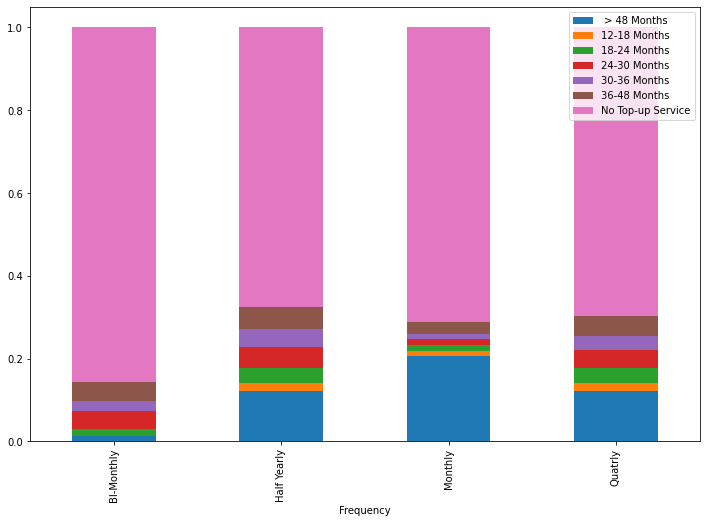

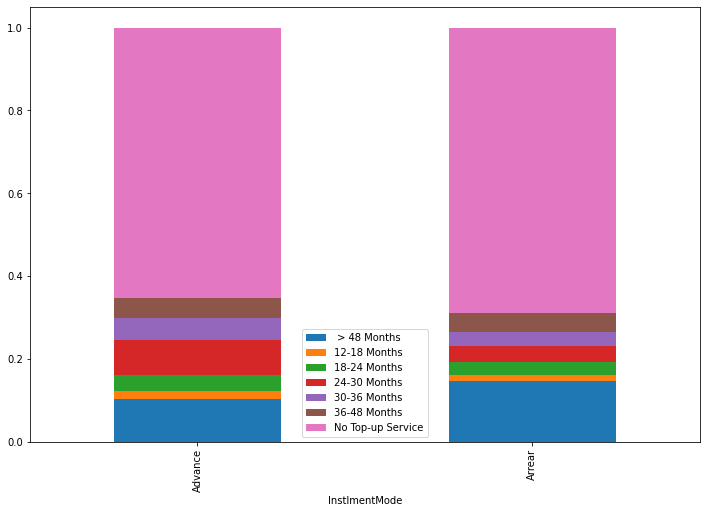

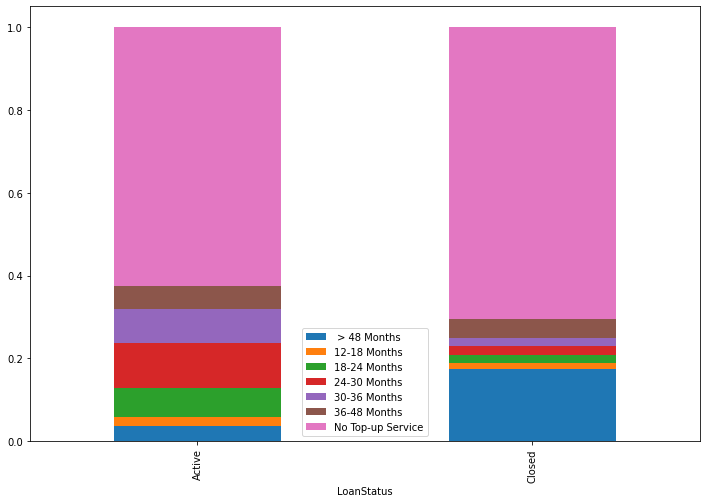

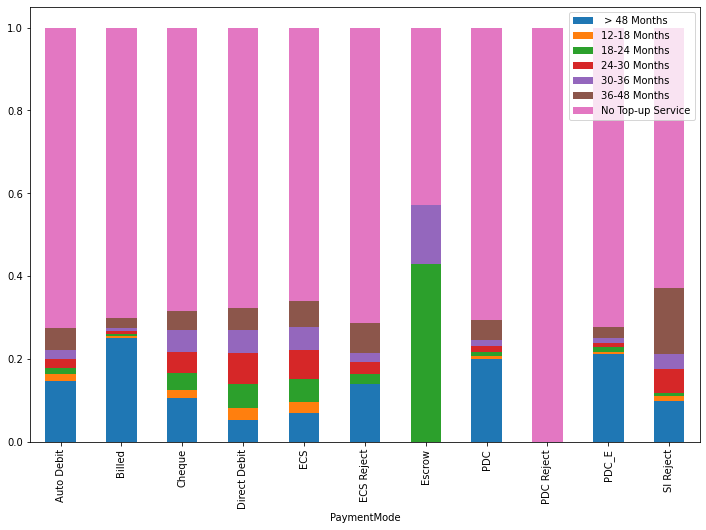

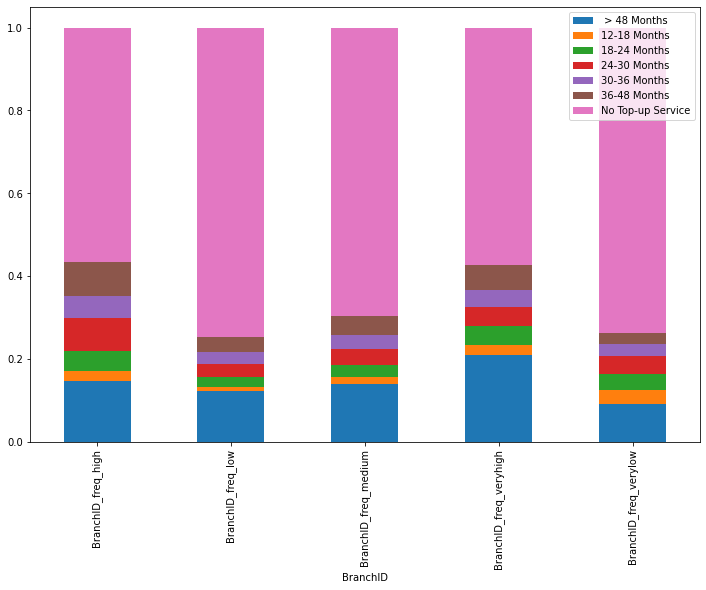

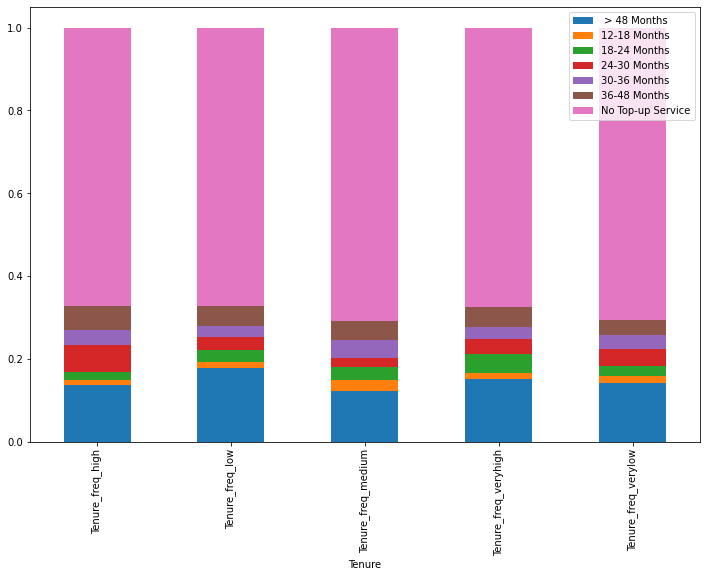

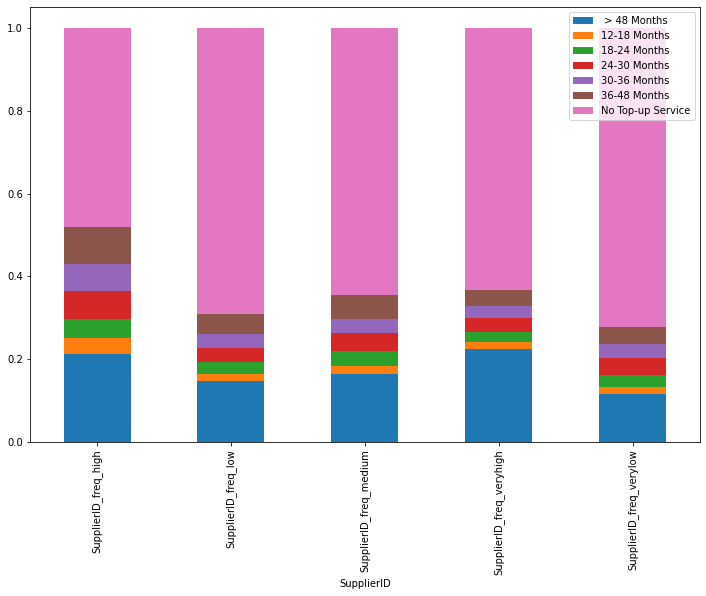

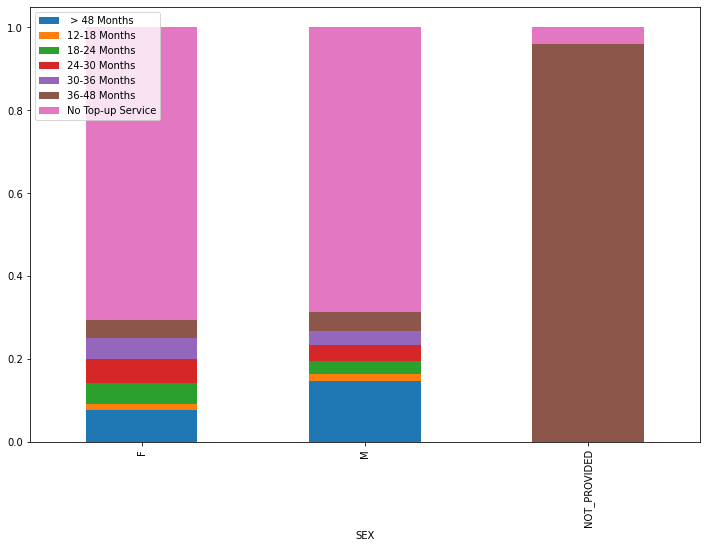

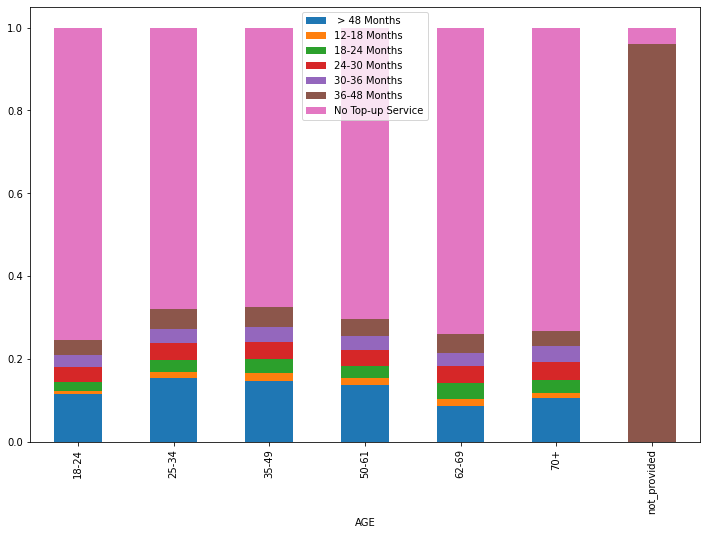

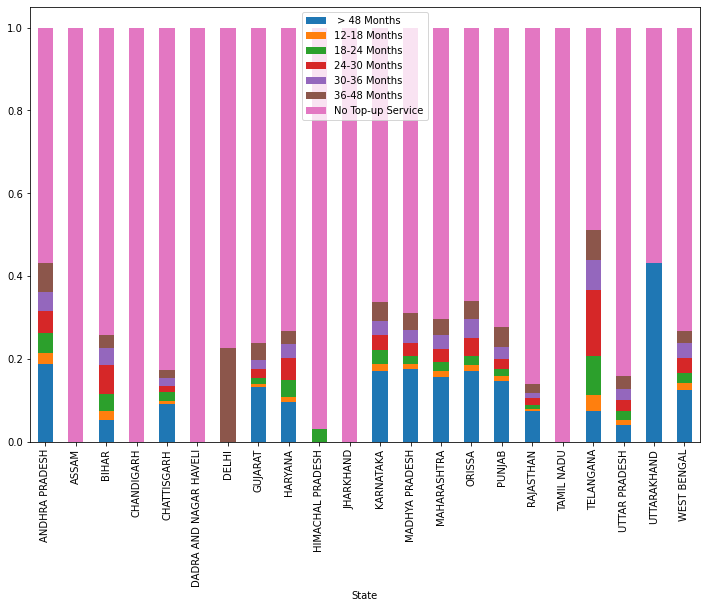

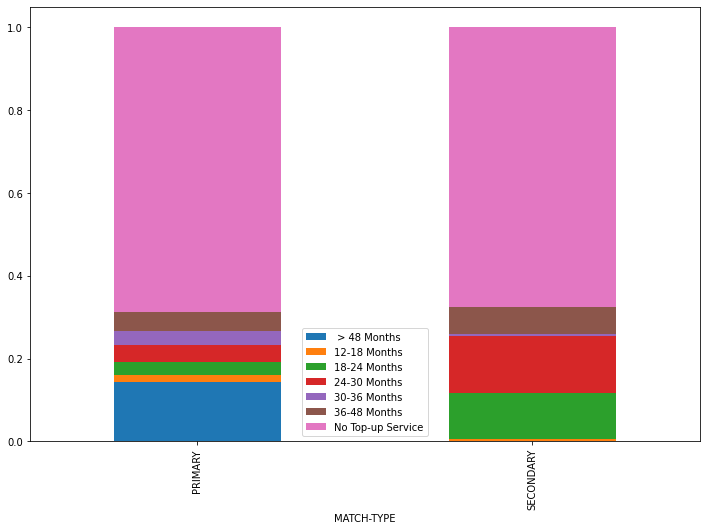

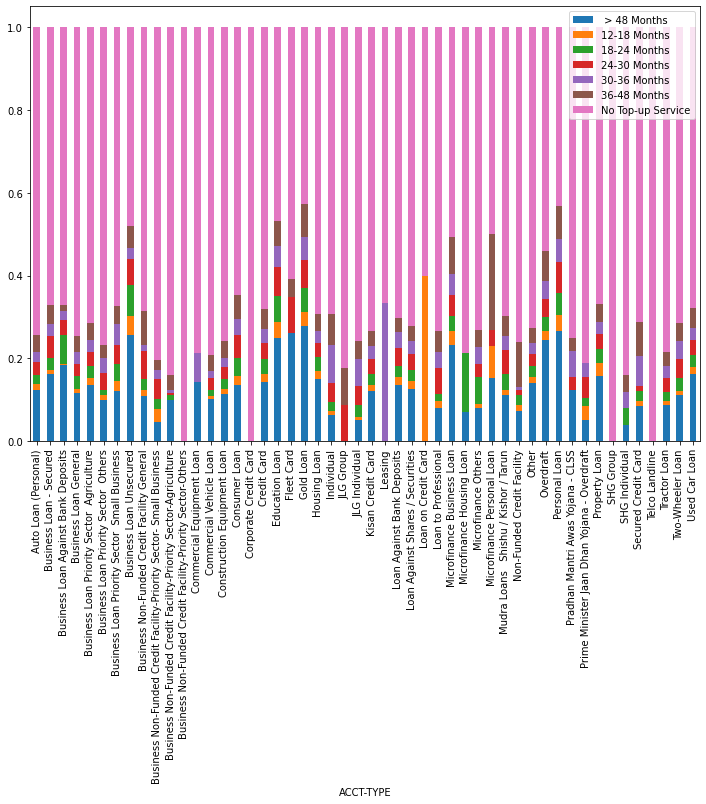

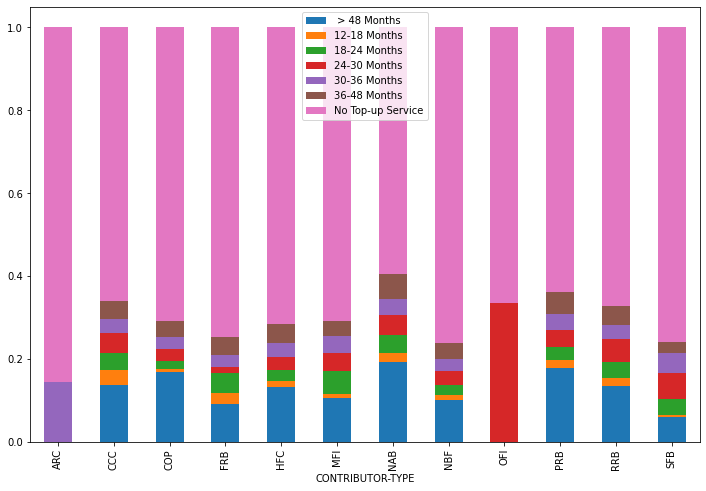

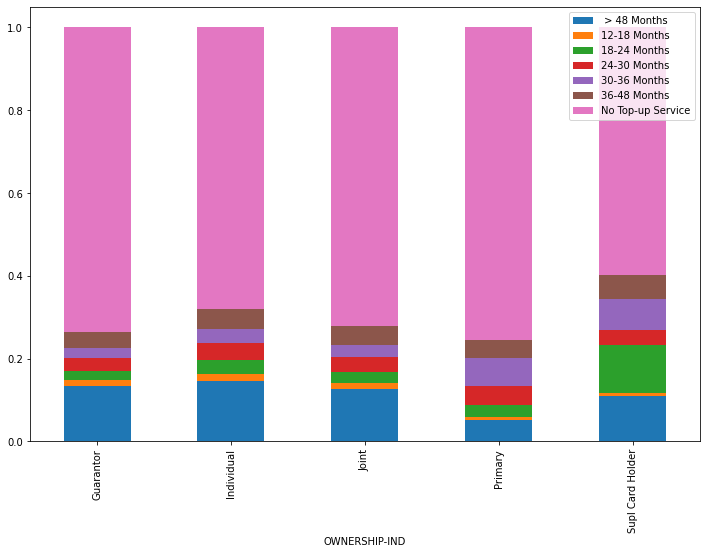

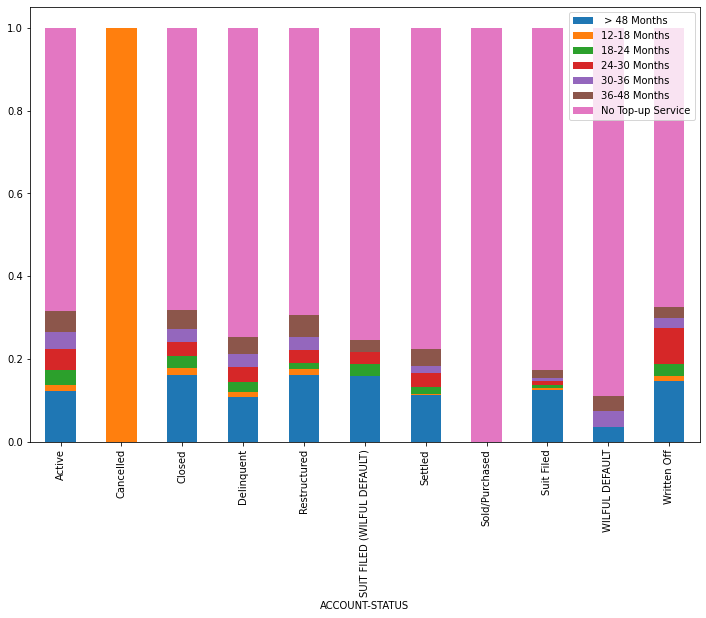

In [ ]:
cat_cols_for_plot  =  full_train_selected.columns[(full_train_selected.columns != 'Top-up Month') == (full_train_selected.dtypes == 'object')]
for i in cat_cols_for_plot:
  plot_bar(full_train_selected[i])

## From above plots we can see
- All featuress(categorical) in some sense affect the chances of a loan top up and period before loan top up

In [ ]:
pd.DataFrame({'UNIQUE VALUES':full_train_selected.nunique().values, 'DTYPES':full_train_selected.dtypes.values} , index = full_train_selected.dtypes.index )

,UNIQUE VALUES,DTYPES
Frequency,4,object
InstlmentMode,2,object
LoanStatus,2,object
PaymentMode,11,object
BranchID,5,object
Tenure,5,object
AssetCost,7820,float64
AmountFinance,20424,float64
DisbursalAmount,19399,float64
EMI,24291,float64


In [ ]:
full_train_selected = full_train_selected.drop('Top-up Month',axis=1) #remove the target column

training_dataset = full_train_selected.copy()

#set all categorical columns to categories
for_catcoding = [i for i in training_dataset.columns if training_dataset[i].dtype != int and training_dataset[i].dtype != float]
# + manufacturer_id
for_catcoding.append('ManufacturerID')

training_dataset[for_catcoding] = training_dataset[for_catcoding].astype('category')
training_dataset = training_dataset.apply(lambda x:x.cat.codes if x.name in for_catcoding else x)

training_dataset.head(7)

,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,State,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-AMT/HIGH CREDIT,CURRENT-BAL,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,LoanDuration
0,2,1,1,9,2,0,450000.0,275000.0,275000.0,24000.0,6,4,61.11,1,2,35833.33,12,0,0,38,6,1,3,37352.0,37873.0,15.0,25346.500000,37873.0,0.0,1435.0
1,2,1,1,9,2,0,450000.0,275000.0,275000.0,24000.0,6,4,61.11,1,2,35833.33,12,0,0,0,6,1,0,44000.0,20797.0,1.0,32804.636364,1452.0,0.0,1435.0
2,2,1,1,9,2,0,450000.0,275000.0,275000.0,24000.0,6,4,61.11,1,2,35833.33,12,1,0,47,7,1,0,145000.0,116087.0,0.0,135362.333333,0.0,0.0,1435.0
3,2,1,1,9,2,0,450000.0,275000.0,275000.0,24000.0,6,4,61.11,1,2,35833.33,12,1,0,0,7,1,2,300000.0,0.0,17.0,125668.885714,485.4,0.0,1435.0
4,2,1,1,9,2,0,450000.0,275000.0,275000.0,24000.0,6,4,61.11,1,2,35833.33,12,1,0,47,7,1,2,275000.0,0.0,0.0,118176.972222,0.0,0.0,1435.0
5,2,1,1,9,2,0,450000.0,275000.0,275000.0,24000.0,6,4,61.11,1,2,35833.33,12,0,0,17,6,1,2,0.0,0.0,0.0,13983.333333,0.0,0.0,1435.0
6,2,1,1,9,2,0,450000.0,275000.0,275000.0,24000.0,6,4,61.11,1,2,35833.33,12,0,0,0,6,1,0,500000.0,443769.0,0.0,473300.428571,0.0,0.0,1435.0


In [ ]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

le = LabelEncoder()
ohe = OneHotEncoder(categories='auto')


In [ ]:
target_variable = le.fit_transform(target)

###Creating model

In [ ]:
#noticed XGBClassifier is somewhat immune to the scaling vs non-scaling

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score 

In [ ]:
x_train,x_test, y_train ,y_test = train_test_split(training_dataset ,target_variable,test_size=0.2,shuffle=False, random_state=12) 

In [ ]:
model  = XGBClassifier(max_depth=10,learning_rate=0.5 ,n_estimators = 200, objective='multi:softmax', colsample_bytree=0.5, reg_alpha=100, reg_lambda=150 )
model.fit(x_train,y_train)
pred = model.predict(x_test)

accuracy_score(y_test,pred), f1_score(y_test,pred ,average='macro')

(0.673625665000806, 0.192957708700605)

In [ ]:
test_data = pd.read_excel('/content/drive/MyDrive/Test.zip (Unzipped Files)/test_Data.xlsx')
test_bureau = pd.read_excel('/content/drive/MyDrive/Test.zip (Unzipped Files)/test_bureau.xlsx')

In [ ]:
full_test_data = pd.merge(test_data, test_bureau , on='ID')
test_dataset_id  = full_test_data ['ID']

In [ ]:
full_test_data[['AMT OVERDUE - HIST','AMT PAID - HIST','CUR BAL - HIST']] = full_test_data[['AMT OVERDUE - HIST','AMT PAID - HIST','CUR BAL - HIST']].apply(lambda x:average_value(x))
full_test_data[['BranchID','SupplierID','Tenure']] = full_test_data[['BranchID','SupplierID','Tenure']].apply(lambda x: freq_grouper(x.name,x))
full_test_data['DISBURSED-AMT/HIGH CREDIT'] = full_test_data['DISBURSED-AMT/HIGH CREDIT'].apply(lambda x:money_to_float(x))
full_test_data['CURRENT-BAL'] = full_test_data['CURRENT-BAL'].apply(lambda x:money_to_float(x))
full_test_data['DPD - HIST'] = full_test_data['DPD - HIST'].apply(lambda x:average_days(x))

#fill nulls for gender and age
full_test_data['SEX'] = full_test_data['SEX'].fillna('NOT_PROVIDED')
full_test_data['AGE'] =  age_bracket(full_test_data['AGE'])

#create a column for loan 
full_test_data['LoanDuration']  = [x.days for x in (full_test_data['MaturityDAte'] - full_test_data['DisbursalDate'])] 


full_test_data = full_test_data.drop(columns_to_drop,axis=1)

full_test_data['AssetCost'] = full_test_data[['AssetCost','DISBURSED-AMT/HIGH CREDIT','CURRENT-BAL']].astype(float)

test_dataset = full_test_data.copy()

test_dataset[for_catcoding] = test_dataset[for_catcoding].astype('category')
test_dataset =test_dataset.apply(lambda x:x.cat.codes if x.name in for_catcoding else x)



In [ ]:
test_dataset = test_dataset.drop([x for x in test_dataset.columns if x not in training_dataset.columns] ,axis=1)

In [ ]:
test_pred = model.predict(test_dataset)

In [ ]:
pred_df = pd.DataFrame({'ID': test_dataset_id , 'Top-up Month':test_pred})
pred_df = pred_df.groupby('ID').mean()
pred_df['Top-up Month'] = le.inverse_transform(pred_df['Top-up Month'].astype(int))
pred_df.to_csv('submission final.csv')